In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geocoder
from time import sleep

In [2]:
from datetime import datetime

In [3]:
from scipy.optimize import fmin, fmin_bfgs, differential_evolution, basinhopping, brute

In [4]:
import seaborn as sns
sns.set(style="ticks", palette="Set2")

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
pwd

'/Users/mmngreco/Documents/repos/unizar/SIAD/Trabajo Grupo'

In [6]:
%matplotlib inline

# PROBLEMA 

## $\min_{x_0, y_0}{\sum{c_i · w_i · d_i}}$

$d_i = \sqrt{(x_i - x_0)^2 + (y_i - y_0)^2}$

__DONDE:__

- $c_i$: Coste ¿unitario?.
- $w_i$: Unidades demandadas de bienes (media de los últimos 3 años)
- $d_i$: Distancia al almacén.
- $x_i$: Coordenada eje x (Longitud)
- $y_i$: Coordenada eje y (Latitud)

__Variables de decisión:__ $x_0, y_0$ 

# SIMULACIÓN

## DEMANDA (CLIENTES)

### SERIE TEMPORAL TIPO:

### $y_t = \delta_0 + \delta_1 · t + u_t$

### Donde:
- $y_t$ : Ventas para cada período t.
- $\delta_0$ : Ventas indendientes o autónomas. (Stock de Seguridad pe.)
- $\delta_1$ : Pendiente la recta.
- $u_t$ : Ruido ~ N(0, 5)

En este caso para darle más realismo, $\delta_0 = \delta_a + \delta_b · sin(x)$, de esta forma introducimos un posible componente estacional, que depende cuán grande sea $\delta_b$.

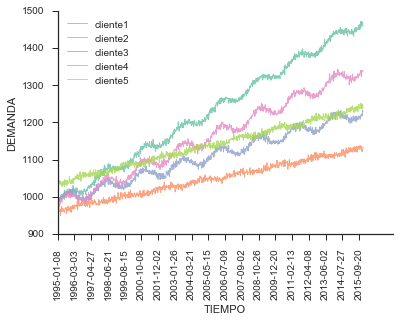

In [7]:
# dda
clientes = dict()
days_by_year = 365
nperiodos = 3 * days_by_year
tiempo = np.linspace(0 , 50, nperiodos)


for c in range(5):

    pendiente = np.random.uniform(0.5, 10)
    ruido = np.random.normal(0, 5, nperiodos)
    freq = np.random.normal(10, 10)
    demanda_a = np.random.normal(1000, 30)
    band = np.random.uniform() < 0.4
    demanda = demanda_a + (np.cos(tiempo)*band + np.sin(tiempo)*(1-band)) * freq + pendiente * tiempo + ruido
    cname = 'cliente%s' % (c+1)
    clientes[cname] = demanda

    plt.plot(demanda, alpha=0.8, label=cname, linewidth=0.91)

sns.despine()
plt.legend(loc=2)
tlabel = pd.date_range(end='2015-12-31', periods=nperiodos, freq='W')
plt.xlabel('TIEMPO')
plt.xticks(range(0, len(tiempo), 60), [t.date() for t in tlabel[0::60]], rotation=90)
plt.ylabel('DEMANDA')

In [8]:
ventas = pd.DataFrame.from_dict(clientes)

In [9]:
tlabel

DatetimeIndex(['1995-01-08', '1995-01-15', '1995-01-22', '1995-01-29',
               '1995-02-05', '1995-02-12', '1995-02-19', '1995-02-26',
               '1995-03-05', '1995-03-12',
               ...
               '2015-10-25', '2015-11-01', '2015-11-08', '2015-11-15',
               '2015-11-22', '2015-11-29', '2015-12-06', '2015-12-13',
               '2015-12-20', '2015-12-27'],
              dtype='datetime64[ns]', length=1095, freq='W-SUN')

In [10]:
ventas.index = tlabel

In [20]:
ventas = pd.read_csv('ventas.csv', index_col=0)

In [21]:
ventas.head()

,cliente1,cliente2,cliente3,cliente4,cliente5
1995-01-08,979.297772,961.956971,991.638215,971.806918,1037.843950
1995-01-15,987.834984,969.170760,987.057280,977.046558,1028.991169
1995-01-22,983.161587,965.986033,991.219179,985.452801,1033.608572
1995-01-29,994.837153,956.812570,991.458601,981.210925,1031.895210
1995-02-05,988.167992,961.285300,993.171938,967.236579,1037.212264


In [12]:
ventas.to_csv('ventas.csv')

# UBICACIÓN DE LOS CLIENTES

In [14]:
data_clientes = pd.read_csv('clientes_xys.csv', index_col=0)

In [15]:
data_clientes

,prov,lat,lng
cliente1,zaragoza,41.648823,-0.889085
cliente2,oviedo,43.361915,-5.849389
cliente3,huesca,42.131845,-0.407806
cliente4,madrid,40.416775,-3.703790
cliente5,bilbao,43.263013,-2.934985


In [16]:
yi = data_clientes.lat.values
xi = data_clientes.lng.values

In [17]:
list(xi)

[-0.88908530000000008,
 -5.8493887000000004,
 -0.4078058,
 -3.7037902000000003,
 -2.9349852000000003]

## COSTES

$c_i$: Es el coste por unidad de producto vendida.

Suponemos que esta empresa ya maximiza beneficios y los precios son exógenos. Por tanto la oferta igual a la demanda, siendo ésta última estimada como la media de los últimos 3 años.

$w_i$ = $E(w_i|T)$

In [23]:
ventas.tail()

,cliente1,cliente2,cliente3,cliente4,cliente5
2015-11-29,1470.640312,1127.582776,1223.692183,1339.580105,1236.293985
2015-12-06,1463.687161,1125.482167,1223.106422,1338.842330,1247.712766
2015-12-13,1465.059974,1120.580199,1217.325679,1336.729573,1238.080532
2015-12-20,1470.140649,1127.666658,1232.473834,1335.836611,1249.316430
2015-12-27,1457.771306,1134.589817,1229.704027,1337.882602,1238.099687


In [26]:
ventas.loc['2012':].head()

,cliente1,cliente2,cliente3,cliente4,cliente5
2012-01-01,1389.376094,1093.134360,1191.986051,1288.293579,1197.473849
2012-01-08,1391.439952,1098.814517,1180.368924,1282.319949,1198.635632
2012-01-15,1383.364158,1088.365951,1187.859712,1270.621878,1206.333424
2012-01-22,1385.592493,1092.388876,1191.696292,1277.646358,1200.752363
2012-01-29,1388.931798,1097.205065,1185.673913,1283.755764,1205.381101


In [27]:
wi = ventas.loc['2012':].mean()
ci = np.random.uniform(1, 100) + 1

In [28]:
wi

cliente1    1423.337483
cliente2    1114.821870
cliente3    1202.542470
cliente4    1307.276005
cliente5    1220.672411
dtype: float64

In [29]:
ci

43.433093077521235

# OPTIMIZACIÓN

In [33]:
fname = 'spain_xys.csv'
fca = 'ca_iso_name_ti.csv'

In [57]:
ca_xys = pd.read_csv(fca, index_col=0)

In [38]:
spain_xys = pd.read_csv(fname)
#muestra_xys.drop_duplicates(inplace=True)

spain_xys.head()

,pais,ca,prov,lat,lng
0,ES,GA,Lugo,42.778861,-7.948673
1,ES,GA,Lugo,42.834314,-7.948673
2,ES,GA,Lugo,42.889767,-7.948673
3,ES,GA,Lugo,42.501594,-7.858738
4,ES,GA,Lugo,42.557048,-7.858738


In [39]:
def func_obj1(xy0):
    'Función Obejtivo, xy0: Tupla, pares de coordenadas'
    di = lambda xy0: np.sqrt((xi-xy0[1]) ** 2 + (yi-xy0[0]) ** 2)
    return sum(wi * ci * di(xy0))
    

In [40]:
res = differential_evolution(func_obj1, [(36,-10),(44,4)])

In [41]:
rrange = (slice(spain_xys.lat.min(),spain_xys.lat.max(), 0.25), 
          slice(spain_xys.lng.min(), spain_xys.lat.max(), 0.25))

In [42]:
res1 = brute(func_obj1, rrange)

In [43]:
res1

array([ 42.09636226,  -2.22411904])

In [44]:
opt = spain_xys.copy()

In [45]:
opt.head()

,pais,ca,prov,lat,lng
0,ES,GA,Lugo,42.778861,-7.948673
1,ES,GA,Lugo,42.834314,-7.948673
2,ES,GA,Lugo,42.889767,-7.948673
3,ES,GA,Lugo,42.501594,-7.858738
4,ES,GA,Lugo,42.557048,-7.858738


In [46]:
opt['fo1'] = opt[['lat', 'lng']].apply(func_obj1, axis=1)

In [47]:
opt[opt.fo1 == opt.fo1.min()]

,pais,ca,prov,lat,lng,fo1
7665,ES,RI,LO,42.113421,-2.192865,567429.511437


# RESULTADO

Con los datos simulados, la solución óptima para el problema planteado es [ 42.23885306,  -2.5716388 ], y la función toma el valor 934296.653775.

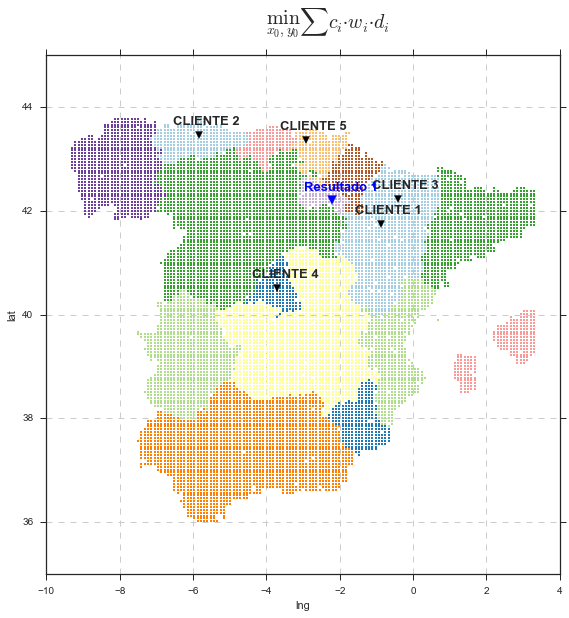

In [56]:
# MAPA
plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)

color = sns.color_palette("Paired", 17)

n_color = list(map(int,'9  7 15 14 12 16 10  1  6  8 11 13  0  2  3  4  5'.split()))

# TERRITORIO
for i, region in enumerate(spain_xys[spain_xys.pais == 'ES'].ca.unique()):
    i = n_color[i]
    spain_xys[spain_xys.ca == region].plot(kind='scatter', 
                                               x='lng', 
                                               y='lat', 
                                               alpha=1, 
                                               ax=ax, 
                                               color=color[i], 
                                               marker='s',
                                               linewidths=.0,
                                               s=5,
                                              )
# CLIENTES
for i, (y, x) in enumerate(zip(data_clientes.lat.values, data_clientes.lng.values)):

    plt.scatter(x, y*1.0025, color='black', marker='v', s=50)
    plt.text(x - 0.7,
             y + 0.3,
             'CLIENTE %s' % (i+1), weight='bold', fontsize=13)

# RESULTADO 1
res = res1
plt.scatter(res[1], 
            res[0]*1.0025, 
            color='blue', 
            marker='v', 
            s=80)

plt.text(res[1] - 0.75, 
         res[0] + 0.3, 
         'Resultado 1',
         weight='bold',
         color='blue',
         fontsize=13)



plt.text(-4, 45.5, '$\min_{x_0,y_0}{\sum{c_i·w_i·d_i}}$', weight='bold', fontsize=20)

plt.xlim(-10,4)
ax.grid(True, linestyle='--')

plt.tight_layout()


> __NOTA:__ 
En los mapas físicos, las coordenadas están expresadas en grados, por ejemplo Puerto Rico sería: 18°14’70” N  66°29’68” W
Para convertir:
- $(18°14'70" N) = (18 + (14 / 60) + (70 / 3600)) = 18.252$
- $(66°29'68" W) = -(66 + (29 / 60) + (68 / 3600)) = -66.8627$

> La longitud se multiplica por __negativo__, porque está a la __izquierda (oeste)__ del punto 0,0.

# INTRODUCCIÓN DE UNA RESTRICCIÓN ADICIONAL

Al problema anterior, le agregamos una variable adicional de tipo fiscal. Cada comunidad autónoma pasará a cobrar un impuesto por unidad vendida, el tipo impositivo dependerá de la comunidad autónoma, de forma que los costes para la empresa cambien y por tanto la elección óptima.

Es decir:

# PROBLEMA INICIAL + RESTRICCIÓN

## $\min_{x_0, y_0}{\sum{c_i(1+t_i) · w_i · d_i}}$

__DONDE:__

- $c_i$: Coste unitario.
- $w_i$: Unidades demandadas de bienes (media de los últimos 3 años).
- $d_i$: Distancia al almacén.
- $x_i$: Coordenada eje x (Longitud).
- $y_i$: Coordenada eje y (Latitud).
- __$t_i$: Impuesto por unidad vendida.__

__Variables de decisión (Coordenadas):__ $x_0, y_0$ 


In [59]:
ca_xys.loc[:,'ti'] = np.random.uniform(size=len(ca_xys))

In [60]:
ca_xys.head()

,codigo,nombre,name.1,ti
name,,,,
AN,ES-AN,Andalucía,AN,0.177949
AR,ES-AR,Aragón,AR,0.158460
AS,ES-AS,"Asturias, Principado de",AS,0.618718
CN,ES-CN,Canarias,CN,0.055673
CB,ES-CB,Cantabria,CB,0.965452


In [61]:
spain_xys.head()

,pais,ca,prov,lat,lng
0,ES,GA,Lugo,42.778861,-7.948673
1,ES,GA,Lugo,42.834314,-7.948673
2,ES,GA,Lugo,42.889767,-7.948673
3,ES,GA,Lugo,42.501594,-7.858738
4,ES,GA,Lugo,42.557048,-7.858738


## FUNCIONES AUXILIARES

In [62]:
# FUNC. AUX.

def xys_ca(xy0):
    '''
    Convierte coordenadas en la CA a la que pertenece
    '''
    d = spain_xys.copy()
    d['dist'] = np.sqrt((d.lat - xy0[0]) ** 2 + (d.lng - xy0[1]) ** 2)
    res = d[d.dist == d.dist.min()]

    if res.dist.values > .1:
        ca = 'nf'
    else:
        ca = res.ca.values[0]

#    print(res)
#    print()
#    print(ca)
    return ca

def impuesto_ca(xy0):
    '''
    Dada una coordenada devuelve el impuesto que tiene asociado a la CA
    '''
    ca = xys_ca(xy0)

    if ca == 'nf':
        res = np.inf
        return res
    else:
        res = ca_xys.loc[ca]
        return res.ti
    

## FUNCIÓN OBJETIVO CON IMPUESTOS

In [63]:
def func_obj(xy0):
    'Función Obejtivo, xy0: Tupla, pares de coordenadas'
    di = lambda xy0: np.sqrt((yi-xy0[0]) ** 2 + (xi-xy0[1]) ** 2)
    res = sum(wi * ci*(1 + impuesto_ca(xy0)) * di(xy0))
    return res

In [64]:
rrange = (slice(spain_xys.lat.min(),spain_xys.lat.max(), 0.25), 
          slice(spain_xys.lng.min(), spain_xys.lat.max(), 0.25))

In [65]:
res2 = brute(func_obj, rrange)

In [66]:
res2

array([ 41.97478821,  -1.87809375])

In [67]:
xys_ca(res)

'RI'

In [68]:
opt['fo2'] = opt[['lat', 'lng']].apply(func_obj, axis=1)

In [69]:
opt.head()

,pais,ca,prov,lat,lng,fo1,fo2
0,ES,GA,Lugo,42.778861,-7.948673,1485654.878663,1935785.080477
1,ES,GA,Lugo,42.834314,-7.948673,1487059.270611,1937614.981228
2,ES,GA,Lugo,42.889767,-7.948673,1488634.359060,1939667.296853
3,ES,GA,Lugo,42.501594,-7.858738,1457649.639499,1899294.691673
4,ES,GA,Lugo,42.557048,-7.858738,1458199.518045,1900011.174823


In [71]:
opt[opt.fo2 == opt.fo2.min()]

,pais,ca,prov,lat,lng,fo1,fo2
8122,ES,AR,Z,41.947062,-1.833126,570676.019775,661105.143846


In [72]:
res2_muestra = opt[opt.fo2 == opt.fo2.min()]

In [81]:
res2_muestra = res2_muestra[['lat', 'lng']].values.flatten()

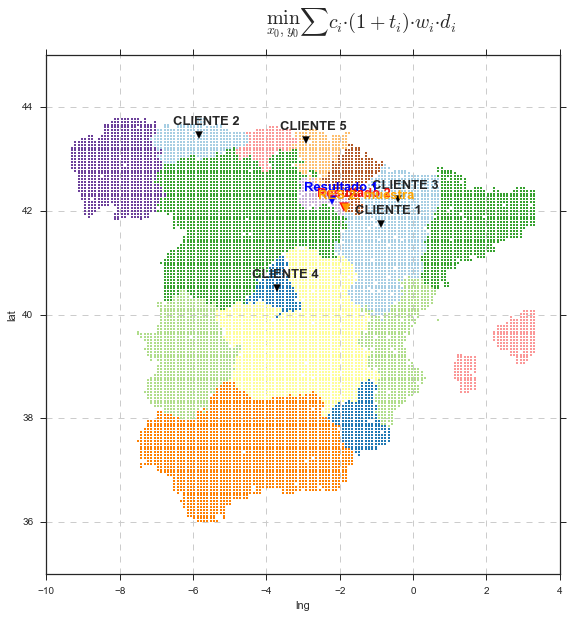

In [122]:
# MAPA
plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)

color = sns.color_palette("Paired", 17)

n_color = list(map(int,'9  7 15 14 12 16 10  1  6  8 11 13  0  2  3  4  5'.split()))

# PINTAR TERRITORIO
for i, region in enumerate(muestra_xys[muestra_xys.pais == 'ES'].ca.unique()):
    i = n_color[i]
    muestra_xys[muestra_xys.ca == region].plot(kind='scatter', 
                                               x='lng', 
                                               y='lat', 
                                               alpha=1, 
                                               ax=ax, 
                                               color=color[i], 
                                               marker='s',
                                               s = 6,
                                               linewidths=.0)
# SITUAR CLIENTES

for i, (y, x) in enumerate(zip(data_clientes.lat.values, data_clientes.lng.values)):

    plt.scatter(x, 
                y*1.0025, 
                color='black', 
                marker='v', 
                s=50)

    plt.text(x - 0.7,
             y + 0.3,
             'CLIENTE %s' % (i+1), 
             weight='bold', 
             fontsize=13)

# RESULTADO 1

res = res1
plt.scatter(res[1], 
            res[0]*1.0025, 
            color='blue', 
            marker='v', 
            s=80)

plt.text(res[1] - 0.75, 
         res[0] + 0.3, 
         'Resultado 1',
         weight='bold',
         color='blue',
         fontsize=13)

# RESULTADO 2

res = res2

plt.scatter(res[1], 
            res[0]*1.0025, 
            color='red', 
            marker='v', 
            s=80)

plt.text(res[1] - 0.75, 
         res[0] + 0.3, 
         'Resultado 2',
         weight='bold',
         color='red',
         alpha=.9,
         fontsize=13)

# RESULTADO 2. MUESTRA

res = res2_muestra

plt.scatter(res[1], 
            res[0]*1.0025, 
            color='orange', 
            marker='v', 
            alpha = .9,
            s=80)

plt.text(res[1] - 0.75, 
         res[0] + 0.3, 
         'RES 2: muestra',
         weight='bold',
         color='orange',
         fontsize=13)

plt.text(-4, 
         45.5, 
         '$\min_{x_0,y_0}{\sum{c_i·(1 + t_i)·w_i·d_i}}$', 
         weight='bold', 
         fontsize=20)

plt.xlim(-10,4)
ax.grid(True, linestyle='--')

plt.tight_layout()

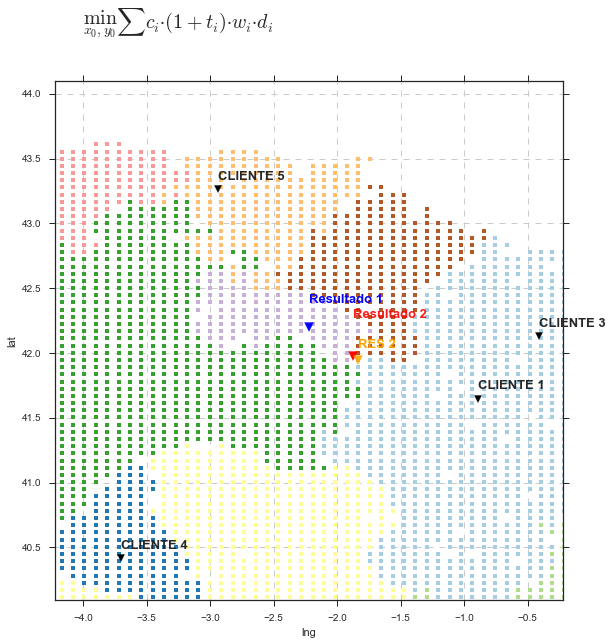

In [131]:
# MAPA
plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)

color = sns.color_palette("Paired", 17)

n_color = list(map(int,'9  7 15 14 12 16 10  1  6  8 11 13  0  2  3  4  5'.split()))

# PINTAR TERRITORIO
for i, region in enumerate(muestra_xys[muestra_xys.pais == 'ES'].ca.unique()):
    i = n_color[i]
    muestra_xys[muestra_xys.ca == region].plot(kind='scatter', 
                                               x='lng', 
                                               y='lat', 
                                               alpha=1, 
                                               ax=ax, 
                                               color=color[i], 
                                               marker='s',
                                               s = 10,
                                               linewidths=.0)
# SITUAR CLIENTES

for i, (y, x) in enumerate(zip(data_clientes.lat.values, data_clientes.lng.values)):
    if i == 1: continue
    plt.scatter(x, 
                y, 
                color='black', 
                marker='v', 
                s=50)

    plt.text(x,
             y + 0.08,
             'CLIENTE %s' % (i+1), 
             weight='bold', 
             fontsize=13)

# RESULTADO 1

res = res1
plt.scatter(res[1], 
            res[0]*1.0025, 
            color='blue', 
            marker='v', 
            s=80)

plt.text(res[1], 
         res[0] + 0.3, 
         'Resultado 1',
         weight='bold',
         color='blue',
         fontsize=13)

# RESULTADO 2

res = res2

plt.scatter(res[1], 
            res[0], 
            color='red', 
            marker='v', 
            s=80)

plt.text(res[1], 
         res[0] + 0.3, 
         'Resultado 2',
         weight='bold',
         color='red',
         alpha=.9,
         fontsize=13)

# RESULTADO 2. MUESTRA

res = res2_muestra

plt.scatter(res[1], 
            res[0], 
            color='orange', 
            marker='v', 
            alpha = .9,
            s=80)

plt.text(res[1], 
         res[0]+.1, 
         'RES 2',
         weight='bold',
         color='orange',
         fontsize=13)

plt.text(-4, 
         44.5, 
         '$\min_{x_0,y_0}{\sum{c_i·(1 + t_i)·w_i·d_i}}$', 
         weight='bold', 
         fontsize=20)

plt.xlim(-10,4)
ax.grid(True, linestyle='--')

c = 4
cx = c-2
res = res1
plt.xlim(res[1] - cx, res[1] + cx)
plt.ylim(res[0] - c+2, res[0] + c-2)
plt.tight_layout()

In [110]:
res1

array([ 42.09636226,  -2.22411904])

In [111]:
res2

array([ 41.97478821,  -1.87809375])

In [115]:
resultados = {'res1': res1, 'res2': res2}

In [116]:
pd.DataFrame.from_dict(resultados)

,res1,res2
0,42.096362,41.974788
1,-2.224119,-1.878094


In [117]:
_.T

,0,1
res1,42.096362,-2.224119
res2,41.974788,-1.878094


In [118]:
_.columns = ['lat', 'lng']

In [119]:
_

,lat,lng
res1,42.096362,-2.224119
res2,41.974788,-1.878094


In [120]:
_.to_csv('resultados.csv')

# Google Maps

![](http://www.elandroidelibre.com/wp-content/uploads/2015/06/google-maps-logo.jpg)

In [121]:
%%HTML
<iframe src="https://mapsengine.google.com/map/embed?mid=zTtXepJtMlLc.k6VXMPFTI7DI" width="740" height="480"></iframe>

In [39]:
# montecarlo
nobs = np.sqrt(20000)
xmin, xmax = -9.29769, 3.29314
ymax = 43.77702
ymin = 36.01356

xs = np.repeat(np.linspace(xmin, xmax, nobs), nobs)
ys = list(np.linspace(ymin, ymax, nobs)) * nobs
ys = np.array(ys).flatten()

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [40]:
n = 11739

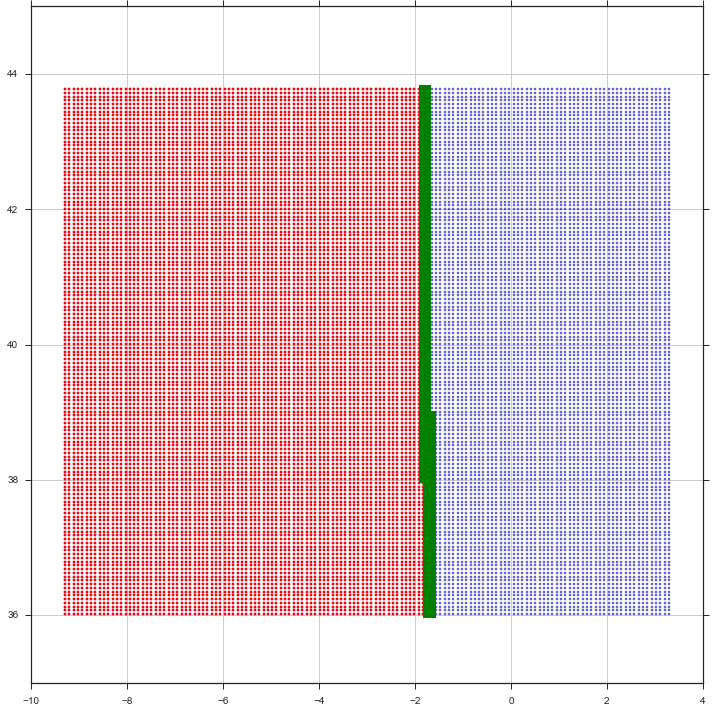

In [41]:
#n = 2500 + 2495
n = n #+ 300
nf = n + 300
plt.figure(figsize=(10,10))
plt.scatter(xs, ys, marker='.', alpha=0.6)
plt.scatter(xs[:n], ys[:n], marker='.', color='red')
plt.scatter(xs[n:nf], ys[n:nf], marker='s', color='g', s=50, linewidth=0, alpha=1)
plt.gca().grid(True)
plt.tight_layout()

# MONTECARLO

## INFORMACIÓN

In [42]:
g = geocoder.google([41.6894079, -0.8427317], method='reverse')

In [43]:
g.json

{'accuracy': 'ROOFTOP',
 'address': 'Diseminado S Gregorio el Cascajo, 9124, 50059 Zaragoza, Zaragoza, Spain',
 'bbox': {'northeast': [41.6924489802915, -0.842331019708498],
  'southwest': [41.6897510197085, -0.8450289802915021]},
 'city': 'Zaragoza',
 'confidence': 9,
 'country': 'ES',
 'county': 'Z',
 'encoding': 'utf-8',
 'housenumber': '9124',
 'lat': 41.6911,
 'lng': -0.84368,
 'location': '41.6894079, -0.8427317',
 'ok': True,
 'postal': '50059',
 'provider': 'google',
 'quality': 'street_address',
 'state': 'Aragón',
 'status': 'OK',
 'status_code': 200,
 'street': 'Diseminado S Gregorio el Cascajo'}

In [44]:
g.json['county']

'Z'

# MUESTREO

In [42]:
calls_remain = 2500

In [68]:
!open report.txt

In [43]:
# googlemaps
# from collections import defaultdict
# montecarlo = defaultdict(lambda : defaultdict(lambda : defaultdict(tuple)))

n = 19163
nf = n + 400

# MUESTREAR

In [365]:
montecarlo = dict()
ini = n
fin = nf

In [366]:
ini, fin

(10077, 10277)

In [367]:
fecha = datetime.now()

In [368]:
report = open('report.txt', 'a')

print('###################### REPORT %s ######################' % fecha, file=report)

for i, yxs in enumerate(zip(ys[ini:fin], 
                          xs[ini:fin])):

    g = geocoder.google(yxs, method='reverse')
    calls_remain -= 1
    print('.', end='')

    try:
        loc = '%s: %s: %s' % (g.json['country'], g.json['state'], g.json['county'])
        print(ini+i, end='\t')
    except:
        print('n:', ini + i,'xys:', yxs, file=report)
        sleep(.8)
        continue

    yx = [list(yxs)]
    montecarlo[loc] = montecarlo.get(loc, yx) + yx
    if calls_remain == 0: break
report.close()
print(calls_remain)

.10077	.10078	.10079	.10080	.10081	.10082	.10083	.10084	.10085	.10086	.10087	..10089	.10090	.10091	.10092	.10093	.10094	.10095	.10096	.10097	.10098	.10099	.10100	.10101	.10102	.10103	.10104	.10105	.10106	.10107	.10108	.10109	.10110	.10111	.10112	.10113	.10114	.10115	.10116	.10117	.10118	.10119	.10120	.10121	.10122	.10123	.10124	.10125	.10126	.10127	.10128	.10129	.10130	.10131	.10132	.10133	.10134	.10135	.10136	.10137	.10138	.10139	.10140	.10141	.10142	.10143	.10144	.10145	.10146	.10147	................10163	.10164	.10165	.10166	.10167	.10168	.10169	.10170	.10171	.10172	..10174	.10175	.10176	.10177	.10178	.10179	.10180	.10181	.10182	.10183	.10184	.10185	.10186	.10187	.10188	.10189	.10190	.10191	.10192	.10193	.10194	.10195	.10196	.10197	.10198	.10199	.10200	.10201	.10202	.10203	.10204	.10205	.10206	.10207	.10208	.10209	.10210	.10211	.10212	.10213	.10214	.10215	.10216	.10217	.10218	.10219	.10220	.10221	.10222	.10223	.10224	.10225	.10226	.10227	.10228	.10229	.10230	.10231	.10232	.10233	.10

# MAPA DEL MUESTREO

In [369]:
montecarlo

{'ES: AL: AL': [[36.623546142857144, -2.8224059999999991],
  [36.623546142857144, -2.8224059999999991],
  [36.67899942857143, -2.8224059999999991],
  [36.734452714285716, -2.8224059999999991],
  [36.789906000000002, -2.8224059999999991],
  [36.845359285714281, -2.8224059999999991],
  [36.900812571428567, -2.8224059999999991],
  [36.956265857142853, -2.8224059999999991],
  [37.011719142857139, -2.8224059999999991],
  [37.067172428571425, -2.8224059999999991],
  [37.122625714285711, -2.8224059999999991],
  [37.233532285714283, -2.8224059999999991]],
 'ES: AL: Granada': [[37.288985571428569, -2.8224059999999991],
  [37.288985571428569, -2.8224059999999991],
  [37.344438857142855, -2.8224059999999991],
  [37.399892142857141, -2.8224059999999991],
  [37.455345428571427, -2.8224059999999991],
  [37.510798714285713, -2.8224059999999991],
  [37.566251999999999, -2.8224059999999991],
  [37.621705285714285, -2.8224059999999991],
  [37.677158571428571, -2.8224059999999991],
  [37.732611857142857,

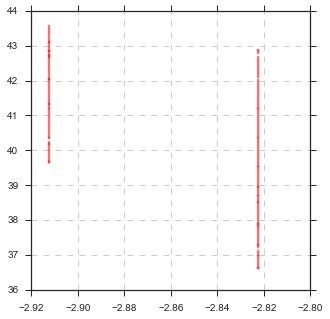

In [370]:
plt.figure(figsize=(5,5))

for k, cs in montecarlo.items():
    x = [c[0] for c in cs]
    y = [c[1] for c in cs]

    if k.startswith('ES'):
        plt.scatter(y, x, color='red', marker='.', alpha=0.5)
    else:
        plt.scatter(y, x, alpha=0.5)

plt.gca().grid(True, linestyle='--')

# ALTERNATIVA

In [371]:
mapquest_api = open('/Users/mmngreco/Documents/mq_api.txt').read()
gmaps_api = open('/Users/mmngreco/Documents/googlemaps_api.txt').read()
geocoder_api = open('/Users/mmngreco/Documents/geocoder_api.txt').read()
mbox_api = open('/Users/mmngreco/Documents/mbox_api.txt').read()

# EXPORTAR DATOS

In [372]:
fname = 'xys.csv'
f = open(fname, 'a')
for key, xys in montecarlo.items():
    for xy in xys:
        print('%s,%s,%s,%s,%s' % (*key.split(': '), *xy), file=f)

f.close()

# COMPROBAMOS LOS DATOS

In [384]:
d = pd.read_csv('xys.csv', header=0)
#d.drop_duplicates(inplace=True)

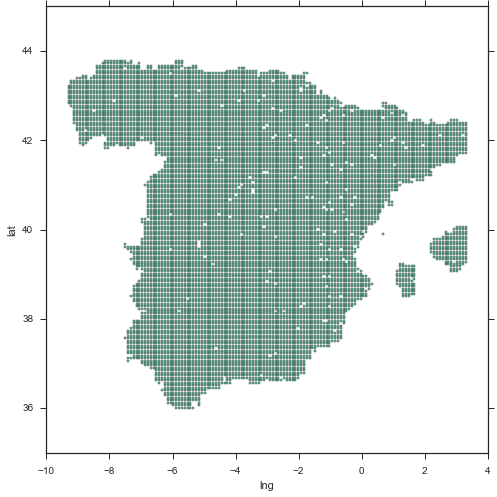

In [386]:
d[d.pais == 'ES'].plot(kind='scatter', x='lng', y='lat', marker='.', figsize=(7,7))
plt.tight_layout()

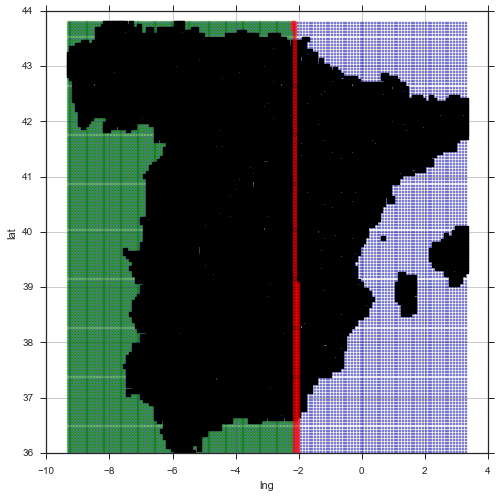

In [391]:
n -= 0
incremento = 200
n = n + incremento
nf = n + incremento

ax = plt.subplot(1,1,1)

ax.scatter(xs, ys, marker='.', alpha=0.5)
ax.scatter(xs[:n], ys[:n], marker='s', color='g', alpha=0.4)
d[d.pais == 'ES'].plot(kind='scatter', x='lng', y='lat', marker='s', figsize=(7,7), ax=ax, color='black', s=25)
ax.scatter(xs[n:nf], ys[n:nf], marker='o', color='r', s=15, linewidth=1, alpha=0.5)
ax.grid(True)

plt.ylim(36,44)
plt.xlim(-10, 4)
plt.tight_layout()

[MUESTREAR](#MUESTREAR)

In [89]:
ca_iso

,codigo,nombre
0,ES-AN,Andalucía
1,ES-AR,Aragón
2,ES-AS,"Asturias, Principado de"
3,ES-CN,Canarias
4,ES-CB,Cantabria
5,ES-CM,Castilla La Mancha ! Castilla-La Mancha
6,ES-CL,Castilla y León
7,ES-CT,Catalunya (ca) [Cataluña]
8,ES-EX,Extremadura
9,ES-GA,Galicia (gl) [Galicia]


In [82]:
prov_iso

,codigo,nombre,ca
0,ES-C,A Coruña (gl) [La Coruña],GA
1,ES-VI,Alava !Álava Araba (eu),PV
2,ES-AB,Albacete,CM
3,ES-A,Alicante Alacant (ca),VC
4,ES-AL,Almería,AN
5,ES-O,Asturias,AS
6,ES-AV,Avila !Ávila,CL
7,ES-BA,Badajoz,EX
8,ES-PM,Balears (ca) [Baleares],IB
9,ES-B,Barcelona [Barcelona],CT


https://es.wikipedia.org/wiki/F%C3%B3rmula_del_Haversine

# CÓDIGO ISO PARA CCAA y PROVINCIAS

In [27]:
url = 'https://en.wikipedia.org/wiki/ISO_3166-2:ES'

# obtener códigos ISO:
ca_iso, prov_iso = pd.read_html(url, header=0, encoding='Latin')[:2]
prov_iso.columns = 'codigo nombre ca'.split()

ca_iso.drop(ca_iso.columns[-1], axis=1, inplace=True)
ca_iso.columns = 'codigo nombre'.split()